# Source
https://roberttlange.github.io/posts/2020/03/blog-post-10/

# Check Device

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Getting started with JAX (MLPs, CNNs & RNNs)
## A Guided Tour Through jit-grad-vmap-scan Wonderland
## Robert Tjarko Lange ([@RobertTLange](https://twitter.com/RobertTLange))

JAX, Jax, JaX. Twitter seems to know nothing else nowadays (next to COVID-19). If you are like me and want to know what the newest hypetrain is about - welcome to todays blog post :hugs:! I will walk you through some exciting CS concepts which were new to me (I am not a computer engineer, so this will be an educational experience for you and me). Along the process, we will go through the individual building blocks of JAX and use them to build some standard Deep Learning architectures (Multilayer Perceptron, Convolutional Neural Nets and a Gated Recurrent Unit RNN) from scratch. In the process we will encounter the basic operators of JAX (`jit`, `vmap`, `grad`), dive deeper into `stax` - the sequential layer API of JAX - and use `lax.scan` to quickly compile the for-loop of an RNN. This should equip you with the basics to start speeding up & optimizing your favorite projects in JAX. Without further ado - here we go!

## What is this JAX thing?

JAX is an automatic differentiation (AD) toolbox developed by a group of people at Google Brain and the open source community. It aims to bring differentiable programming in NumPy-style onto TPUs. On the highest level JAX combines the previous projects [XLA](https://www.tensorflow.org/xla) & [Autograd](https://github.com/hips/autograd) to accelorate your favorite linear algebra-based projects.

<img align="center" src="JAX-Blog.jpg" data-canonical-src="JAX-Blog.jpg" width="500" height="500"/>

Python as an interpreted programming language is slow by nature. It translates one program statement to machine code at a time and computations may get stuck in the global interpreter lock (GIL). So in order to train networks at scale we need fast compilation and parallel computing! Complied CUDA kernels for example provide a set of primitive instructions which can be executed massively parallel on a NVIDIA GPU. The computation graph generated by PyTorch or TensorFlow can then be compiled into a sequence of executions (basic operations, e.g. add/multiply) with precompiled kernels. Ideally, we want to launch as few kernels as possible because this reduces communication times and memory load. And this is where *XLA* comes in. It optimizes memory bandwith by "fusing" operations and reduces the amount of returned intermediate computations. In practice this can help to significantly spead up things.

*Autograd*, on the other hand, provides automatic differentiation support for large parts of standard Python features. AD resembles the backbone of optimization in Deep Learning. It simplifies the derivative expression of a compositional function at every possible point in time. For a vast set of basic math operations we already know the functional form of their derivative. By the beauty of the chain rule, we can combine these elementary derivative and reduce the complexity of the expression at the cost of memory storage. This allows us to compute gradients which we can then use to optimize the parameters of our models using our favorite gradient-based optimization algorithm. Broadly speaking there are two types of automatic differentiation: [Forward and backward mode](https://roberttlange.github.io/posts/2019/08/blog-post-6/) (aka backpropagation). JAX supports AD for standard NumPy functions as well as loops which transform numerical variables.

In principle these ingredients make JAX's applicability a lot broader than Deep Learning and provide another step into the era of "Code 2.0" and differentiable programming. Many recent projects focus on DL applications (such as **[rlax](https://github.com/deepmind/rlax)**, or **[haiku](https://github.com/deepmind/dm-haiku)** - two of DeepMind's recent open source releases) but there are also other examples which benefit from buth Numba-like speed-ups with some gradient-sauce on top (e.g. [*Hamiltonian Monte-Carlo*](https://github.com/ethanluoyc/dhmc-jax)). I personally, often times find myself working on projects in which I use Numba to generate synthetic data and PyTorch to train networks. JAX allows me to write all within a single framework. Furthermore, getting started in JAX comes very natural because many people deal with NumPy syntax/conventions on a daily basis. So let's get started by importing the basic JAX ingredients we will need in this Tutorial.

In [3]:
!nvidia-smi

Mon May 25 17:27:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 25%   49C    P2    60W / 250W |    157MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:09:00.0 Off |                  N/A |
| 23%   46C    P2    61W / 250W |    157MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

We simply import the JAX version of NumPy as well as the good old vanilla version. Most of the standard NumPy functons are supported (see [here](https://jax.readthedocs.io/en/latest/jax.numpy.html) for an overview) by JAX and can be called in the standard fashion. JAX automatically detects whether you have access to a GPU or TPU.

And here is also the first difference to classic NumPy. We generate random numbers using JAX's random library and a previously generated random key. Unlike NumPy JAX uses an explicit pseudorandom number generator (PRNG). What does this mean? In order to parallelize random computations across resources, one needs to be able to fork a random number generators state. This can only be done by explicitly passing and iterating of the generators state. We will later when we generate parameters for our neural nets see how this comes in handy. So let's generate a random matrix and perform a simple matrix-matrix multiplication:

In [5]:
# Generate a random matrix
x = random.uniform(key, (1000, 1000))
# Compare running times of 3 different matrix multiplications
%time y = onp.dot(x, x)
%time y = np.dot(x, x)
%time y = np.dot(x, x).block_until_ready()

CPU times: user 49.9 ms, sys: 4.08 ms, total: 54 ms
Wall time: 35 ms
CPU times: user 670 ms, sys: 103 ms, total: 773 ms
Wall time: 275 ms
CPU times: user 601 µs, sys: 363 µs, total: 964 µs
Wall time: 692 µs


Tada :tada: - even simple matrix multiplication can be speed up quite a bit.

On a different note: Often times people post their crazy speed-ups when using JAX. *Lazy Execution* refers to an evaluation strategy that performs computation only when truly needed (e.g. when printing). Hence, it can make some wall time numbers deceiving. This is due to fact that is does not return the actual result of the computation. Instead the measured time only reflects the dispatching! Blocking the computation (via `.block_until_ready()`) enforces the actual computation and prevents JAX to simply run forward without evaluation. Only this way the time estimates provide a realistic measure to compare performance.

## A Few Basic Concepts & Conventions - jit, grad & vmap

Before diving into the nitty-gritty details of training some neural nets in JAX, let's have a look at the basic ingredients that make things work. **jit** (just-in-time compilation) lies at the core of speeding up your code. In practice we simply wrap (`jit()`) or decorate (`@jit`) the function of interest.

In [6]:
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)

The first time we call the jitted function it will be compiled and it may take a little longer. But afterwards, the machine code is ready to shine.

In [7]:
%time out = ReLU(x).block_until_ready()
# Call jitted version to compile for evaluation time!
%time jit_ReLU(x).block_until_ready()
%time out = jit_ReLU(x).block_until_ready()

CPU times: user 14.7 ms, sys: 17.9 ms, total: 32.6 ms
Wall time: 75.8 ms
CPU times: user 16 ms, sys: 17.1 ms, total: 33.2 ms
Wall time: 78.7 ms
CPU times: user 992 µs, sys: 0 ns, total: 992 µs
Wall time: 729 µs


The next tool in our kit is **grad**. It is the autodiff backbone of JAX and is inherited from the Autograd package. By wrapping your function with grad and evaluating it, you get the gradient evaluation returned. Let's have a look at how this would work with our ReLU activation function:

In [8]:
def FiniteDiffGrad(x):
    """ Compute the finite difference derivative approx for the ReLU"""
    return np.array((ReLU(x + 1e-3) - ReLU(x - 1e-3)) / (2 * 1e-3))

# Compare the Jax gradient with a finite difference approximation
print("Jax Grad: ", jit(grad(jit(ReLU)))(2.))
print("FD Gradient:", FiniteDiffGrad(2.))

Jax Grad:  1.0
FD Gradient: 0.99998707


Now that we know how to speed up functions and how to compute gradients, we come to the next gem: **vmap** - which makes batching as easy as never before. While in PyTorch one always has to be careful over which dimension you want to perform computations, vmap lets you simply write your computations for a single sample case and afterwards wrap it to make it batch compatible. It is as easy as that. Let's say you have a 100 dimensional feature vector and want to process it by a linear layer with 512 hidden units & your ReLU activation. And let's say you want to compute the layer activations for a batch with size 32.

In [9]:
batch_dim = 32
feature_dim = 100
hidden_dim = 512

# Generate a batch of vectors to process
X = random.normal(key, (batch_dim, feature_dim))

# Generate Gaussian weights and biases
params = [random.normal(key, (hidden_dim, feature_dim)),
          random.normal(key, (hidden_dim, ))] 

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(np.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

out = np.stack([relu_layer(params, X[i, :]) for i in range(X.shape[0])])
out = batch_version_relu_layer(params, X)
out = vmap_relu_layer(params, X)

In jax it is convenient to keep all model parameters in a dictionary. This makes your life easier when you have to decide which dimension you want to batch/vmap over. `vmap` wraps the `relu_layer` function and takes as an input the axis over which to batch the inputs. In our case the first input to `relu_layer` are the parameters which are the same for the entire batch. The second input is the feature vector. We have stacked the vectors into a matrix such that our input has dimensions `(batch_dim, feature_dim)`. We therefore need to provide `vmap` with batch dimension (0) in order to properly parallelize the computations. `out_axes` than specifies how to stack the individual samples outputs. In order to keep things consistent, we choose the first dimension to remain the batch dimension.

## Training a MNIST Multilayer Perceptron in JAX

At this point we got all the basic ingredients to start training our first JAX-powered deep learning model. We will start by defining a simple PyTorch MNIST dataloader and afterwards set everything up to train. JAX is a purely functional programming framework. Hence, we cant wrap things in class instances or modules used for example from the PyTorch `nn.Module` semantics. We, therefore, will need the following functions to train a Multilayer Perceptron:

- A function that **initializes the neural networks weights** and returns a list of layer-specific parameters.
- A function that performs a **forward pass** through the network (e.g. by loop over the layers).
- A function that computes the **cross-entropy loss** of the predictions.
- A function that **evaluates the accuracy** of the network (simply for logging).
- A function that **updates the parameters** using some form gradient descent.

All of these will then be tied together in a training loop. We start by importing some additional helpers (including the optimizers from JAX) and the dataset from PyTorch. Any other dataloader will do the job similarly as long as transform the inputs to JAX-NumPy arrays.

In [10]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

import torch
from torchvision import datasets, transforms

import time
from helpers import plot_mnist_examples

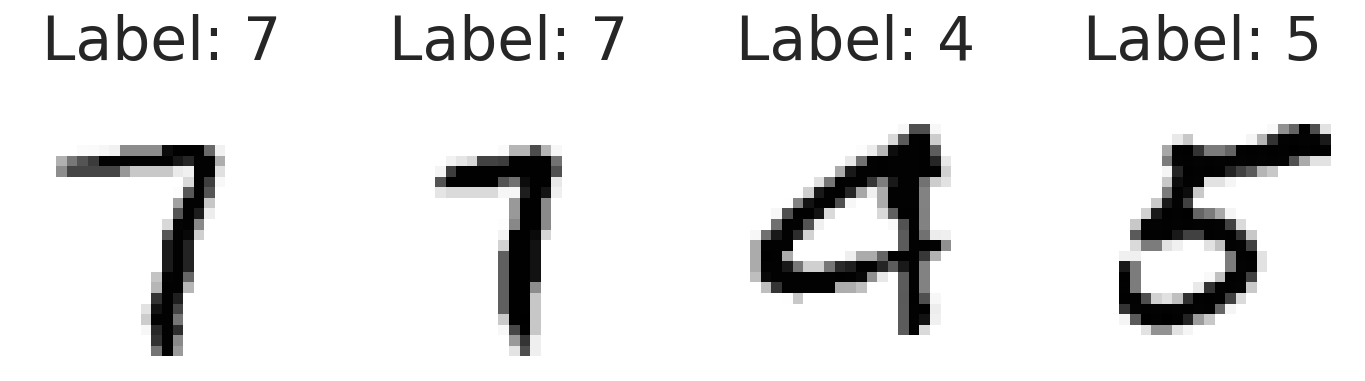

In [11]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)


plot_mnist_examples(train_loader)

Next we will need a function that initializes the weights in our MLP. We will pass a list of hidden layer sizes and the previously generated PRNG key. We need to split the key iteratively to generate the individual weights of our network. Let's see how this is done for a MLP that takes the flat MNIST image as an input (28 x 28 = 784) and has two hidden layers with 512 units (e.g. 784-512-512-10).

In [14]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

Now we define the forward pass through the network by iteratively looping over the layers and returning the log of the softmax output/predictions. Afterwards, we `vmap` the single case to create a batched version.

In [15]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array
    
    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)
    
    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

Now we need some gradient-sauce: In order to get there we need to define which function we would like to optimize. This is going to be the multi-class cross-entropy loss between the one-hot encoded class labels ($y_i \in \mathbb{R}^{10}$) and the softmax output of the network ($p^\theta(x_i) \in \mathbb{R}^{10}$):

$$ - \sum_{c=1}^{10} y_{ic} \log p^\theta_{c}(x_i) $$

Finally, for logging purposes we compute the accuracy as well.

In [16]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)
  
def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)
    
        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(batch_forward(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

We can now put things together into a single `update` function that computes the gradient of the loss with respect to the parameters for a batch. We use the predefined optimizers and choose Adam to be our optimizer for the initialized parameters and we are ready!

In [17]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10

Having setup everything - it is time to run the learning loop for the 2-layer MLP!

Epoch 1 | T: 12.03 | Train A: 0.974 | Test A: 0.967
Epoch 2 | T: 11.11 | Train A: 0.984 | Test A: 0.975
Epoch 3 | T: 11.10 | Train A: 0.989 | Test A: 0.978
Epoch 4 | T: 11.11 | Train A: 0.991 | Test A: 0.977
Epoch 5 | T: 11.11 | Train A: 0.994 | Test A: 0.980
Epoch 6 | T: 11.10 | Train A: 0.995 | Test A: 0.979
Epoch 7 | T: 11.09 | Train A: 0.997 | Test A: 0.983
Epoch 8 | T: 11.15 | Train A: 0.996 | Test A: 0.981
Epoch 9 | T: 11.11 | Train A: 0.998 | Test A: 0.979
Epoch 10 | T: 11.08 | Train A: 0.996 | Test A: 0.982


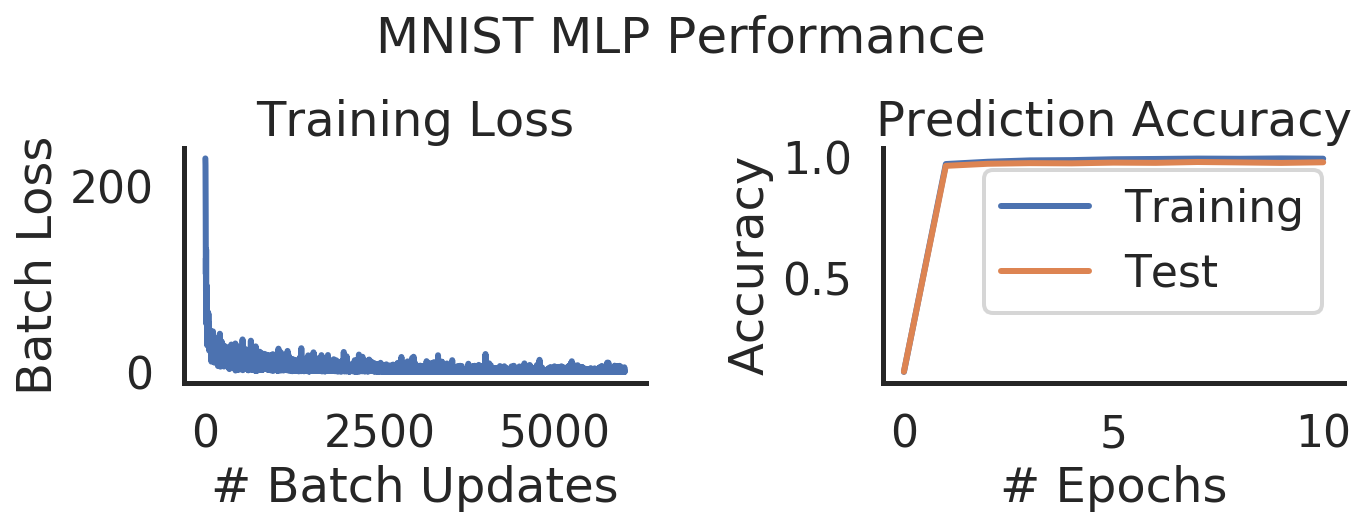

In [18]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []
    
    # Get the initial set of parameters 
    params = get_params(opt_state)
    
    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)
    
    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    
    return train_loss, log_acc_train, log_acc_test

train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")

# Plot the loss curve over time
from helpers import plot_mnist_performance
plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST MLP Performance")

## Using the `stax` API to build Sequential Models - Case Study: A CNN

Until now we have defined our forward pass manually by looping over the individual layers and performing the ReLU layer transformations. This can be a little awkward but allows for maximal control over the computations. Alternatively, Jax similarly to PyTorch and Keras provides a higher-level layer of abstraction. Let me introduce you to `stax` and a simple CNN example.  

In [19]:
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)

The `stax` API has a set of predefined input transformations predefined and ready to use. These include almost all standard feedforward operations. We can chain them using the `stax.serial` wrapper. Here is an example of a ConvNet that applies batch normalization and a Relu activation after each convolutional layer:

In [20]:
init_fun, conv_net = stax.serial(Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
                                 Flatten,
                                 Dense(num_classes),
                                 LogSoftmax)

_, params = init_fun(key, (batch_size, 1, 28, 28))

The output returns a function to initialize the parameters of the network as well as a function to apply the forward pass through the network with. When initializing we have to specify the shape of the desired input as well as the batch dimension. Similarly as before we can then proceed to define the loss and accuracy. The only difference compared to the MLP case is that we no longer flatten the image.

In [21]:
def accuracy(params, data_loader):
    """ Compute the accuracy for the CNN case (no flattening of input)"""
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data)
        targets = one_hot(np.array(target), num_classes)
    
        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(conv_net(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

def loss(params, images, targets):
    preds = conv_net(params, images)
    return -np.sum(preds * targets)

We can then run the learning loop again!

Epoch 1 | T: 14.47 | Train A: 0.969 | Test A: 0.967
Epoch 2 | T: 11.85 | Train A: 0.980 | Test A: 0.973
Epoch 3 | T: 11.79 | Train A: 0.984 | Test A: 0.976
Epoch 4 | T: 11.75 | Train A: 0.985 | Test A: 0.976
Epoch 5 | T: 11.81 | Train A: 0.988 | Test A: 0.979
Epoch 6 | T: 11.76 | Train A: 0.990 | Test A: 0.981
Epoch 7 | T: 11.73 | Train A: 0.991 | Test A: 0.981
Epoch 8 | T: 11.74 | Train A: 0.992 | Test A: 0.982
Epoch 9 | T: 11.80 | Train A: 0.993 | Test A: 0.981
Epoch 10 | T: 11.80 | Train A: 0.993 | Test A: 0.981


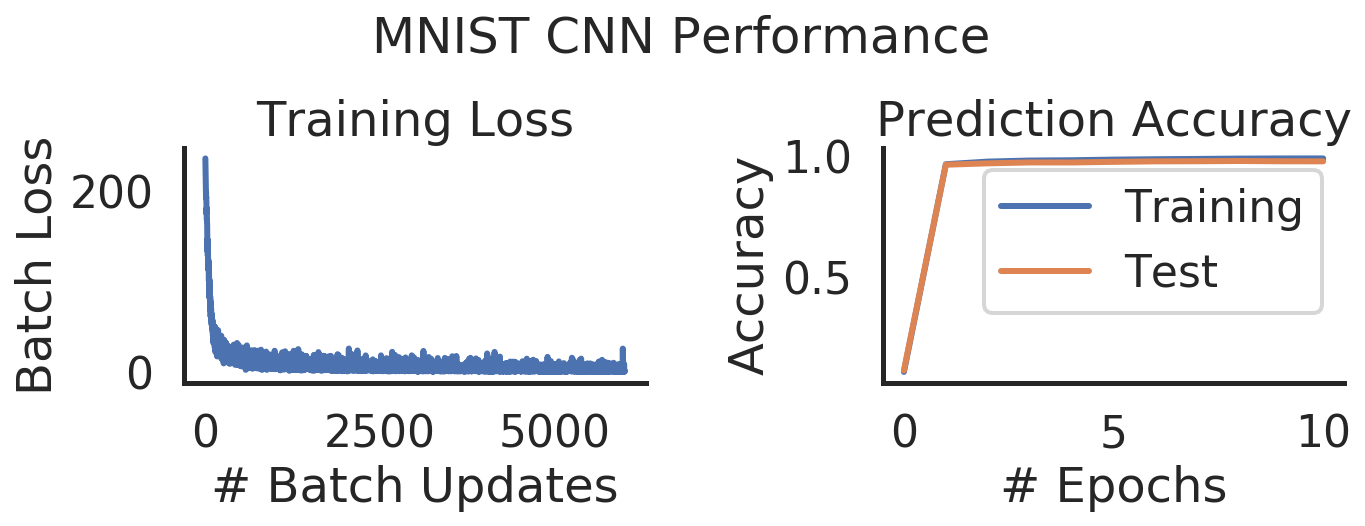

In [22]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
num_epochs = 10

train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="CNN")
    
plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST CNN Performance")

Again training is smooth and the time per epoch is similar to the MLP. This is interesting since we are currently training on CPU which means that the 2D convolution can't be as easily parallelized as on the GPU. Still the compilation seems to work overtime!

## Training RNNs with `jax.lax.scan`

To be entirely honest, RNNs in Jax are a bit awkward. The `stax` API until now only supports feedforward transformations and we have to work around things a little (I have an [open pull request](https://github.com/google/jax/pull/2298) but there is still some functionality missing). Everything is possible... but requires a little more brain stretching. Furthermore, the sequentiality of the for-loop is somewhat nasty in terms of compilation. But we will figure out how to get around that. In what follows we will try to learn to predict the next denoised values of a noisy version of the [Ornstein-Uhlenbeck (OU) process](https://de.wikipedia.org/wiki/Ornstein-Uhlenbeck-Prozess) with a Gated Recurrent Unit (GRU) network.

**Data Generation**: JAX unfortunately has some weird characteristics when it comes to inplace replacements. Therefore, we go back to traditional NumPy to generate our Ornstein-Uhlenbeck process. We first sequentially generate the OU time series and afterwards add Gaussian noise on top. The RNN later on will try to denoise the noisy OU and to recover the original time series.

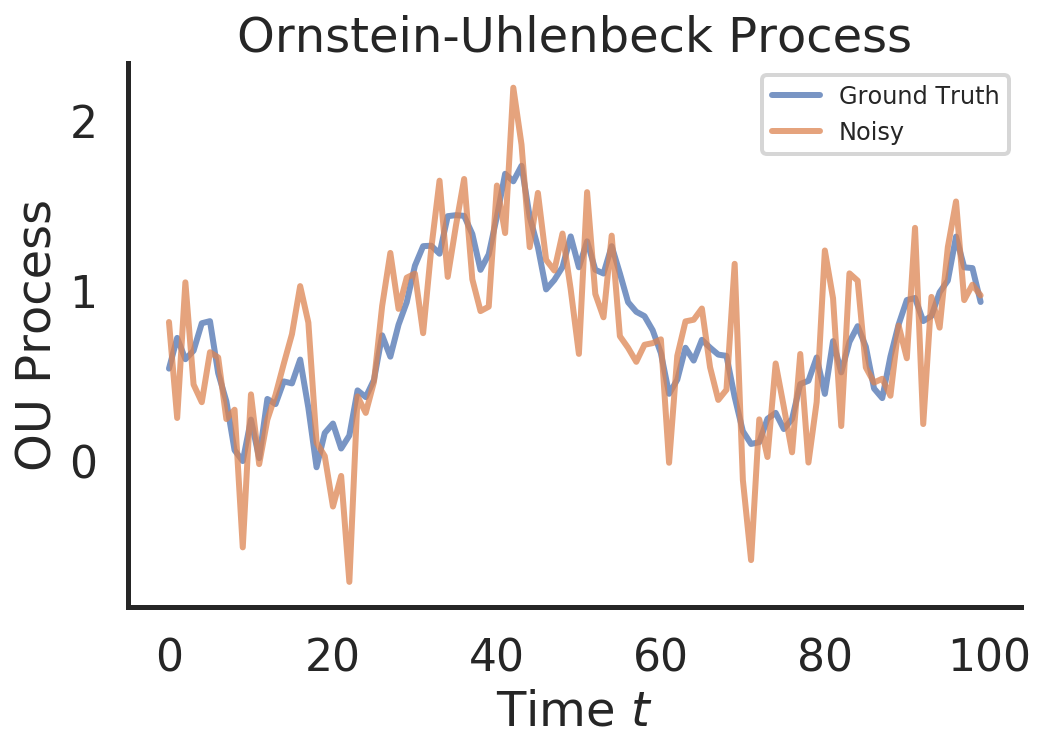

In [23]:
# Generate & plot a time series generated by the OU process
from helpers import generate_ou_process, plot_ou_process
x_0, mu, tau, sigma, dt = 0, 1, 2, 0.5, 0.1
noise_std = 0.1
num_dims, batch_size = 100, 50  # Number of timesteps in process

x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau,
                                 sigma, noise_std, dt)
plot_ou_process(x[0, :], x_tilde[0, :])

Next we need to define our GRU layer. We do so by coding up the following hidden state update equations:

- **Update gate**: $z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)$
- **Reset gate**: $r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)$
- **Hidden state**: $h_z = z_t \circ h_{t-1} + (1-z_t) \circ tanh(W_h x_t + U_h (r_t \circ h_{t-1} + b_h)$

Ultimately, we want to learn the weight matrices and biases: $W_z, U_z, b_z, W_r, U_r, b_r, W_h, U_h, b_h$. Here is the functional JAX/`stax` version:

In [24]:
from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal

from functools import partial
from jax import lax

def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """ Initialize the GRU layer for stax """
        hidden = b_init(rng, (input_shape[0], out_dim))

        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)
        # Input dim 0 represents the batch dimension
        # Input dim 1 represents the time dimension (before scan moveaxis)
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
            (hidden,
             (update_W, update_U, update_b),
             (reset_W, reset_U, reset_b),
             (out_W, out_U, out_b),),)

    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        h = params[0]
        
        def apply_fun_scan(params, hidden, inp):
            """ Perform single step update of the network """
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b), (
                out_W, out_U, out_b) = params

            update_gate = sigmoid(np.dot(inp, update_W) +
                                  np.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(np.dot(inp, reset_W) +
                                 np.dot(hidden, reset_U) + reset_b)
            output_gate = np.tanh(np.dot(inp, out_W) 
                                  + np.dot(np.multiply(reset_gate, hidden), out_U) 
                                  + out_b)
            output = np.multiply(update_gate, hidden) + np.multiply(1-update_gate, output_gate)
            hidden = output
            return hidden, hidden

        # Move the time dimension to position 0
        inputs = np.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, h_new = lax.scan(f, h, inputs)
        return h_new

    return init_fun, apply_fun

All of the stax function are structured in a similar way. You have a sub-function that initializes the parameters of the layer & another `apply_fun` that performs the transformation to the input given the parameters of the layer. Something that is special about the computations in an RNN is that we have to keep track of the hidden state. This is here done by defining the hidden state $h_t$ as a parameter in the `params` dictionary. One benefit (or problem) of this is that we learn the initial hidden state as well. Furthermore, we would get into trouble if we simply wrote down a for-loop for executing the RNN over multiple timesteps. This is because JAX would try to compile the relevant functions for every timestep. And this may take a while. In order to overcome this we have to use `lax.scan`: 

> *scan is a JAX primitive and is lowered to a single XLA While HLO. That makes it useful for reducing compilation times for jit-compiled functions, since native Python loop constructs in an @jit function are unrolled, leading to large XLA computations.* - [ReadTheDocs](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html)

In order to make use of such a powerful tool we need to define a single time step update & this is what is done in `apply_fun_scan`. We use `partial` to "clone" all the parameters to use at all timesteps. As before we can now "instantiate" our RNN and all required ingredients using the `stax` syntax. We choose the hidden state to have dimension 12 and the mean-squared erro loss function.

In [25]:
num_dims = 10              # Number of OU timesteps
batch_size = 64            # Batchsize
num_hidden_units = 12      # GRU cells in the RNN layer 

# Initialize the network and perform a forward pass
init_fun, gru_rnn = stax.serial(Dense(num_hidden_units), Relu,
                                GRU(num_hidden_units), Dense(1))
_, params = init_fun(key, (batch_size, num_dims, 1))

def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = gru_rnn(params, inputs)
    return np.mean((preds - targets)**2)

@jit
def update(params, x, y, opt_state):
    """ Perform a forward pass, calculate the MSE & perform a SGD step. """
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, loss

We will train our GRU-RNN to learn to predict the data-generating process of an Ornstein-Uhlenbeck process. Initially it may be hopeless to generate an entire sequence of the process, $x_1, x_2, ..., x_T$ end-to-end without additional help. Therefore, we will make use of a technique called **teacher forcing**.

<img align="center" src="teacher_forcing.png" data-canonical-src="teacher_forcing.png" width="500" height="500"/>

In teacher forcing we do not only use the next time step $x_{t+1}$ to compute the loss of the prediction (e.g. MSE: $||x_{t+1} - \hat{x}_{t+1}||_2^2||$) but also as an input to the next time step. In our case we want the network to also learn the denoising and therefore, do not use the denoised OU version $x_{t+1}$ but the noisy $\tilde{x}_{t+1}$ as the input. Thereby, the network is aided in its learning process. Later on, after the network has learned parts of the generating dynamics we can disable the teacher assistance and let the network generate the entire sequence. We can then start to let the gradients flow again:

In [26]:
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_batches = 1000

train_loss_log = []
start_time = time.time()
for batch_idx in range(num_batches):
    x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
    x_in = np.expand_dims(x_tilde[:, :(num_dims-1)], 2)
    y = np.array(x[:, 1:])
    params, opt_state, loss = update(params, x_in, y, opt_state)
    batch_time = time.time() - start_time
    train_loss_log.append(loss)

    if batch_idx % 100 == 0:
        start_time = time.time()
        print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))

Batch 0 | T: 1.63 | MSE: 0.59 |
Batch 100 | T: 0.40 | MSE: 0.37 |
Batch 200 | T: 0.38 | MSE: 0.18 |
Batch 300 | T: 0.39 | MSE: 0.18 |
Batch 400 | T: 0.38 | MSE: 0.14 |
Batch 500 | T: 0.38 | MSE: 0.10 |
Batch 600 | T: 0.38 | MSE: 0.10 |
Batch 700 | T: 0.38 | MSE: 0.09 |
Batch 800 | T: 0.38 | MSE: 0.09 |
Batch 900 | T: 0.38 | MSE: 0.11 |


Let's now have a closer look at the loss and the time series predictions!

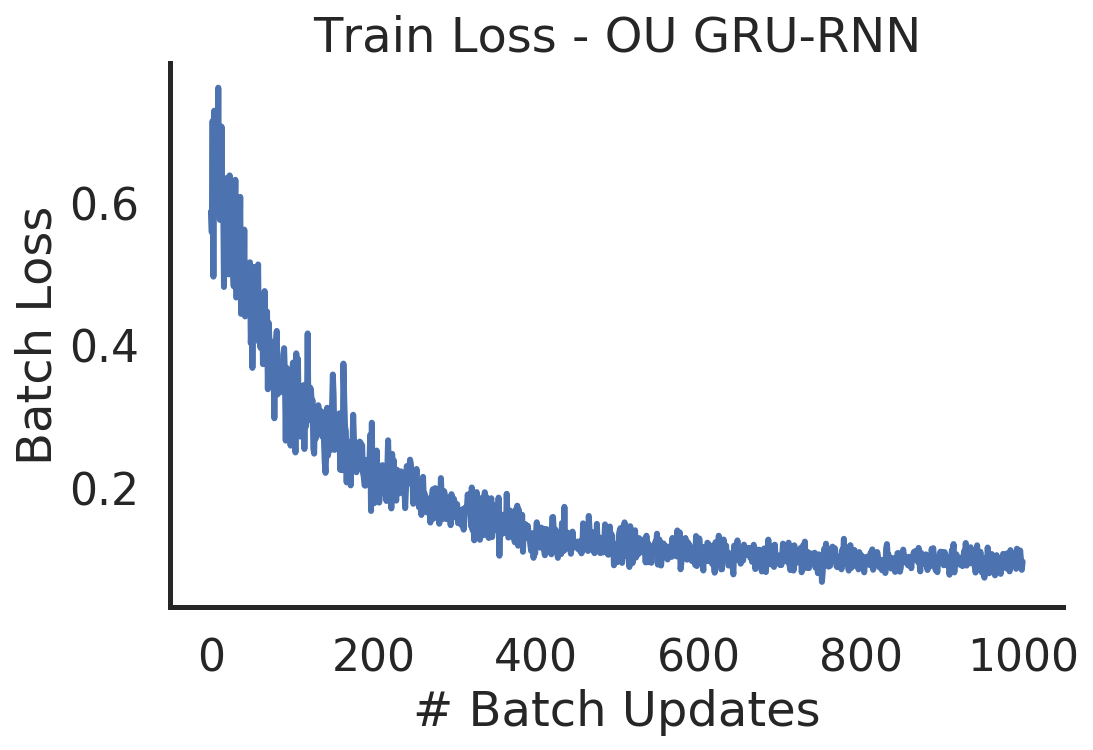

In [27]:
# Plot the training loss for OU-GRU-RNN!
from helpers import plot_ou_loss
plot_ou_loss(train_loss_log)

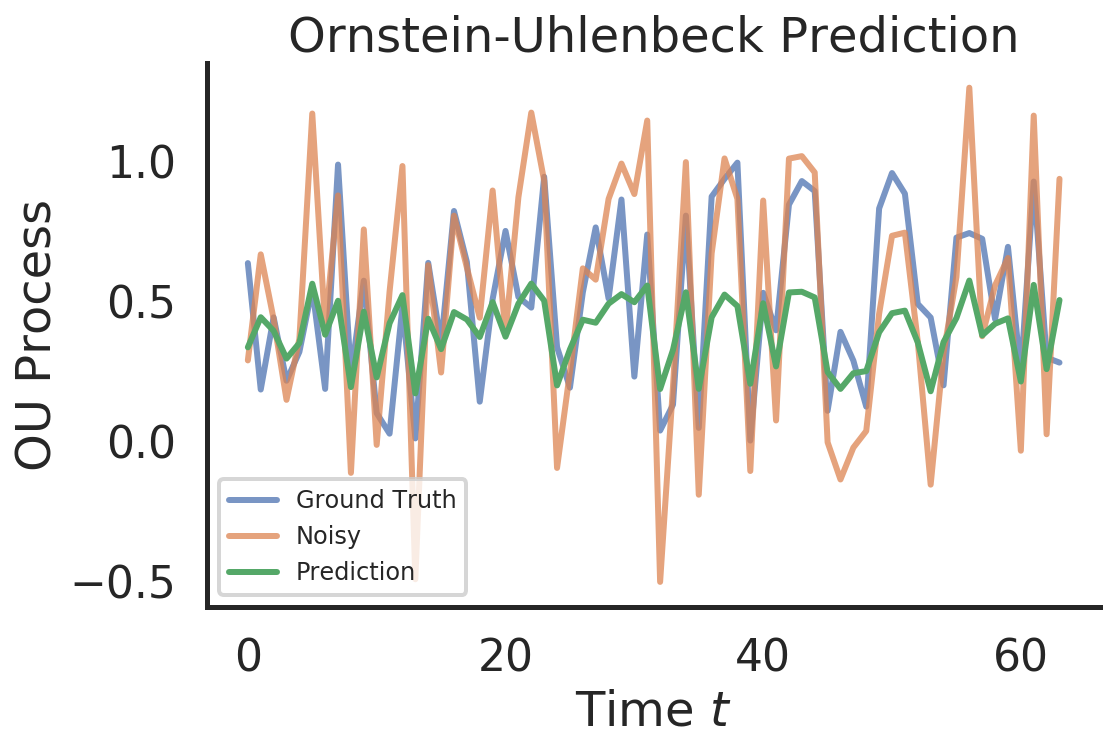

In [28]:
# Plot a prediction and ground truth OU process
x_true, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
x = np.expand_dims(x_tilde[:, :(num_dims-1)], 2)
y = np.array(x[:, 1:])
preds = gru_rnn(params, x)

x = onp.array(x)
y = onp.array(y)
x_pred = onp.array(preds)
plot_ou_process(x_true[:, 0], x_tilde=x_tilde[:, 0], x_pred=x_pred[0, :],
               title=r"Ornstein-Uhlenbeck Prediction")

As we can observe the training loss goes down and the RNN is able to fit a sampled test sequence from the OU process fairly well. It appears that the denoising overshoots a little. The smooting seems to regulate the activity to the mean $\mu = 0.5$ which is the desired behavior.

## Concluding Thoughts & What am I missing

We have seen the power of combining autograd and XLA compilation to train networks fast and efficiently on your accelarator. What am I personally missing? Here is a short list:

1. Some mechanism to fix parameters to not be optimized.
2. More diversity - initializations, optimizers, multi-head attention layer.
3. Many small things (log pdf evaluation of the multivariate normal).

These are mainly tools that are specific to Deep Learning applications and I am fairly sure that they will become solved/added as we go along and more people start to pick up JAX. I am still a little undecided whether right now is the right time to fully jump onto JAX. There are still many question marks (e.g. how do I dettach variables from the computational graph). Switching would require me to rewrite quite a bit of my PyTorch codebase... What do you think?

P.S.: Get started with contributing :bowtie:!

# Credits
- Colling Raffel's intro [blog post](https://colinraffel.com/blog/you-don-t-know-jax.html).
- The basic MLP example is adopted from the [Jax documentation](https://github.com/google/jax/blob/master/docs/notebooks/Neural_Network_and_Data_Loading.ipynb).
- The RNN structure is inspired by ['Computation Through Dynamics'](https://github.com/google-research/computation-thru-dynamics/tree/master/integrator_rnn_tutorial) ressources by David Sussillo.